In [130]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import sys
import os
import scipy.stats as stats
import pickle
import lightgbm as lgbm


pd.set_option("display.max_rows", 1000)

sys.path.append("..")
from utils import reduce_mem_usage
from tqdm import tqdm
from loguru import logger
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [6]:
def read_data(data_dir):
    sales = pd.read_csv(os.path.join(data_dir, "sales_train_evaluation.csv"))
    calendar = pd.read_csv(os.path.join(data_dir, "calendar.csv"))
    prices = pd.read_csv(os.path.join(data_dir, "sell_prices.csv"))
    submission = pd.read_csv(os.path.join(data_dir, "sample_submission.csv"))

    #     sales = reduce_mem_usage(sales)
    #     calendar = reduce_mem_usage(calendar)
    #     prices = reduce_mem_usage(prices)
    #     submission = reduce_mem_usage(submission)

    return sales, calendar, prices, submission

<IPython.core.display.Javascript object>

In [7]:
sales, calendar, prices, submission = read_data("../data/")

<IPython.core.display.Javascript object>

In [11]:
def create_shifted_feature(
    data: pd.DataFrame, lag: int = 28, feature_col: str = "sales", id_col: str = "id",
) -> pd.DataFrame:
    feat = data.groupby(id_col)[feature_col].shift(-lag).fillna(0)
    return feat


def preprocess_calendar(calendar: pd.DataFrame) -> pd.DataFrame:
    calendar = calendar.copy()
    event_name_map = {mod: i for i, mod in enumerate(calendar["event_name_1"].unique())}
    event_type_map = {mod: i for i, mod in enumerate(calendar["event_type_1"].unique())}

    calendar["event_name"] = calendar["event_name_1"]
    calendar["event_type"] = calendar["event_type_1"]

    #     calendar["event_name"] = calendar["event_name"].map(event_name_map)
    #     calendar["event_type"] = calendar["event_type"].map(event_type_map)
    calendar["d"] = calendar["d"].str.replace("d_", "").astype(int)
    calendar["wday"] -= 1
    calendar["month"] -= 1
    calendar["year"] -= 2011
    calendar["week_number"] = pd.to_datetime(calendar["date"]).dt.week

    calendar = calendar.sort_values("date")
    calendar = calendar.drop(
        [
            "event_name_1",
            "event_name_2",
            "event_type_1",
            "event_type_2",
            #             "date",
            #             "weekday",
        ],
        axis=1,
    )
    return calendar


def preprocess_sales(sales):
    sales = sales.copy()
    series_cols = sales.columns[sales.columns.str.contains("d_")].values
    level_cols = sales.columns[~sales.columns.str.contains("d_")].values
    sales = sales.melt(level_cols, series_cols, var_name="day", value_name="sales")
    sales["day"] = sales["day"].str.replace("d_", "").astype(int)
    return sales


def merge_and_melt(sales, calendar, prices):
    logger.info("preprocessing")
    sales = preprocess_sales(sales)
    calendar = preprocess_calendar(calendar)

    logger.info("merging with calendar, prices")
    # merge with calendar
    sales = sales.merge(
        calendar, left_on="day", right_on="d", validate="many_to_one", how="left"
    )
    sales = sales.merge(
        prices,
        left_on=["item_id", "store_id", "wm_yr_wk"],
        right_on=["item_id", "store_id", "wm_yr_wk"],
        validate="many_to_one",
        how="left",
    )
    return sales


def intervaled_cumsum(a, trigger_val=1, start_val=0, invalid_specifier=-1):
    out = np.ones(a.size, dtype=int)
    idx = np.flatnonzero(a == trigger_val)
    if len(idx) == 0:
        return np.full(a.size, invalid_specifier)
    else:
        out[idx[0]] = -idx[0] + 1
        out[0] = start_val
        out[idx[1:]] = idx[:-1] - idx[1:] + 1
        np.cumsum(out, out=out)
        out[: idx[0]] = invalid_specifier
        return out


def feature_engineering(
    sales: pd.DataFrame, ahead_windows=[3, 7, 14, 28]
) -> pd.DataFrame:

    logger.info("feature engineeering")
    # impute missing data on sell price
    sales["sell_price"] = sales.groupby("item_id")["sell_price"].apply(
        lambda x: x.fillna(x[~x.isnull()].median())
    )

    # make rolling averages/std for items
    windows = [3, 7, 30, 90, 180, 360]
    for window in tqdm(windows, desc="fe: rolling stats"):
        sales.loc[:, f"rolling_sales_mean_{window}"] = (
            sales.groupby(["id"])["sales"]
            .transform(lambda x: x.rolling(window=window).mean())
            .astype(np.float16)
            .fillna(0)
        )
        sales.loc[:, f"rolling_sales_std_{window}"] = (
            sales.groupby(["id"])["sales"]
            .transform(lambda x: x.rolling(window=window).std())
            .astype(np.float16)
            .fillna(0)
        )

    # difference between short-long trends
    short_windows = [3, 7, 30]
    long_windows = [90, 180, 360]

    for short_window in tqdm(short_windows, desc="fe: long-short term diff"):
        for long_window in long_windows:
            sales.loc[:, f"trend_diff_{short_window}_{long_window}"] = (
                sales[f"rolling_sales_mean_{short_window}"]
                - sales[f"rolling_sales_mean_{long_window}"]
            )

    # store-wise rolling average

    # see if in a zero plateau
    sustained_zero = (
        sales.groupby("id")["sales"]
        .apply(lambda x: intervaled_cumsum(x == 0))
        .explode()
        .astype(int)
    )
    sustained_zero.name = "days_sustained_zero"
    sustained_zero = sustained_zero.reset_index()
    sustained_zero.loc[:, "day"] = sustained_zero.groupby("id").transform(
        lambda x: np.arange(len(x)) + 1
    )

    sales = sales.merge(sustained_zero, on=["id", "day"], how="left", copy=False)

    # create target variable
    for ahead in tqdm(ahead_windows, desc="fe: ahead target"):
        y_ahead = create_shifted_feature(sales, ahead)
        sales.loc[:, f"target_shift_{ahead}"] = y_ahead

    # shift future events back
    for ahead in tqdm(ahead_windows, desc="fe: ahead events"):
        event_type_ahead = create_shifted_feature(
            sales, ahead, feature_col="event_type"
        ).replace({0: "No events"})
        event_name_ahead = create_shifted_feature(
            sales, ahead, feature_col="event_name"
        ).replace({0: "No events"})
        weekday_ahead = create_shifted_feature(sales, ahead, feature_col="weekday")

        weekend_ahead = weekday_ahead.isin({0, 1}).astype(int)
        friday_ahead = (weekday_ahead == 6).astype(int)

        sales.loc[:, f"event_type_shift_{ahead}"] = event_type_ahead
        sales.loc[:, f"event_name_shift_{ahead}"] = event_name_ahead
        sales.loc[:, f"weekend_shift_{ahead}"] = weekend_ahead
        sales.loc[:, f"friday_shift_{ahead}"] = friday_ahead

    return sales

<IPython.core.display.Javascript object>

In [9]:
AHEAD_WINDOWS = [3, 7, 14, 28]

<IPython.core.display.Javascript object>

In [12]:
data_saved = os.path.isfile("../data/train.h5")
# data_saved = False
if data_saved:
    data = pd.read_hdf("../data/train.h5")
else:
    data = merge_and_melt(sales, calendar, prices)
    data = feature_engineering(data, AHEAD_WINDOWS)
    data = reduce_mem_usage(data)

    data.to_hdf("../data/train.h5", key="train", format="table")

2022-04-30 00:05:24.683 | INFO     | __main__:feature_engineering:86 - feature engineeering
fe: ahead events: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:40<00:00, 40.24s/it]


Memory usage of dataframe is 22237.16 MB
Memory usage after optimization is: 5984.00 MB
Decreased by 73.1%


<IPython.core.display.Javascript object>

In [153]:
dump_cols = [
    "id",
    "wm_y_wk",
    "event_name",
    "d",
    "day",
    "event_type",
    "wm_yr_wk",
    "weekday",
    "date",
] + [c for c in data.columns if c.startswith("target")]
feat_cols = [c for c in data.columns if c not in dump_cols]
cat_cols = [
    "item_id",
    "dept_id",
    "cat_id",
    "store_id",
    "state_id",
    "event_name_shift_3",
    "event_name_shift_7",
    "event_name_shift_14",
    "event_name_shift_28",
    "event_type_shift_3",
    "event_type_shift_7",
    "event_type_shift_14",
    "event_type_shift_28",
    "weekend_shift_3",
    "friday_shift_3",
    "weekend_shift_7",
    "friday_shift_7",
    "weekend_shift_14",
    "friday_shift_14",
    "weekend_shift_28",
    "friday_shift_28",
]

cont_cols = [c for c in feat_cols if c not in cat_cols]

<IPython.core.display.Javascript object>

In [27]:
### ENCODE CATEGORICAL VARIABLES
encode_dict = {}

for col in cat_cols:
    lbe = LabelEncoder()
    lbe.fit(data[col])
    data.loc[:, col] = lbe.fit_transform(data[col])
    encode_dict[col] = lbe

pickle.dump(encode_dict, open("../models/encoders.pkl", "wb"))

<IPython.core.display.Javascript object>

In [173]:
cat_mean_dict = {col: train.groupby(col)["sales"].mean().to_dict() for col in cat_cols}

<IPython.core.display.Javascript object>

In [ ]:
cat_mean_dict['']

### Bayseian Ridge

In [152]:
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler

<IPython.core.display.Javascript object>

In [174]:
val_preds = []
test_preds = []

bayes_models = []

for ahead_by in tqdm(AHEAD_WINDOWS, leave=False):
    target_col = f"target_shift_{ahead_by}"

    train = data[data["day"] < 1914 - ahead_by]  # need to subtract lag used
    val = data[(1914 - ahead_by <= data["day"]) & (data["day"] < 1914)]
    test = data[(data["day"] >= 1914) & (data["day"] < 1942)]

    for col, mean in cat_mean_dict.items():
        train[col] = train[col].replace(mean)
        val[col] = val[col].replace(mean)
        test[col] = test[col].replace(mean)

    X_train, y_train = train[feat_cols], train[target_col]
    X_val, y_val = val[feat_cols], val[target_col]
    X_test, y_test = test[feat_cols], test[target_col]

    ### TRAIN LGBM MODEL
    preproc = StandardScaler()
    X_train.loc[:, cont_cols] = preproc.fit_transform(X_train[cont_cols])
    X_val.loc[:, cont_cols] = preproc.transform(X_val[cont_cols])
    X_test.loc[:, cont_cols] = preproc.transform(X_test[cont_cols])

    bayes_model = BayesianRidge()
    bayes_model.fit(X_train, y_train)

    pickle.dump(bayes_model, open(f"../models/bayes_{ahead_by}.pkl", "wb"))

    bayes_models.append(bayes_model)

    val_pred = bayes_model.predict(X_val)
    test_pred = bayes_model.predict(X_test)

    val_preds.append(val_pred)
    test_preds.append(test_pred)
#     break

  0%|                                                                                                                                                                                                                          | 0/4 [00:00<?, ?it/s]/tmp/ipykernel_3814859/3879309616.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col] = train[col].replace(mean)
/tmp/ipykernel_3814859/3879309616.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val[col] = val[col].replace(mean)
/tmp/ipykernel_381485

<IPython.core.display.Javascript object>

In [203]:
shortest_length = len(min(val_preds, key=len))
val_pred_bayes = np.mean(
    [val_pred[-shortest_length:] for val_pred in val_preds], axis=0
)
test_pred_bayes = np.mean(test_preds, axis=0)

<IPython.core.display.Javascript object>

In [204]:
mean_squared_error(y_val.values[-shortest_length:], val_pred_bayes, squared=False)

2.286640423469562

<IPython.core.display.Javascript object>

### LGBM

In [144]:
model_params = {
    "n_estimators": 1000,
    "num_leaves": 100,
    "max_depth": 9,
    "learning_rate": 0.03,
    "boosting_type": "gbdt",
    "objective": "poisson",
    "metric": "rmse",
    "reg_alpha": 0.2,
    "reg_lambda": 0.2,
    "subsample": 0.6,
    "categorical_feature": [
        i for i in range(len(feat_cols)) if feat_cols[i] in cat_cols
    ],
    "min_split_gain": 0.02,
}

<IPython.core.display.Javascript object>

In [182]:
val_preds_lgbm = []
test_preds_lgbm = []

lgbm_models = []

for ahead_by in tqdm(AHEAD_WINDOWS, leave=False):
    target_col = f"target_shift_{ahead_by}"

    train = data[data["day"] < 1914 - ahead_by]  # need to subtract lag used
    val = data[(1914 - ahead_by <= data["day"]) & (data["day"] < 1914)]
    test = data[(data["day"] >= 1914) & (data["day"] < 1942)]

    X_train, y_train = train[feat_cols], train[target_col]
    X_val, y_val = val[feat_cols], val[target_col]
    X_test, y_test = test[feat_cols], test[target_col]

    ### TRAIN LGBM MODEL
    train_dataset = lgbm.Dataset(X_train, y_train)
    val_dataset = lgbm.Dataset(X_val, y_val)

    lgbm_model = lgbm.train(
        model_params,
        train_dataset,
        300,
        valid_sets=[train_dataset, val_dataset],
        verbose_eval=100,
        early_stopping_rounds=100,
    )

    pickle.dump(lgbm_model, open(f"../models/lgbm_poisson_{ahead_by}.pkl", "wb"))

    lgbm_models.append(lgbm_model)

    val_pred = lgbm_model.predict(X_val)
    test_pred = lgbm_model.predict(X_test)

    val_preds_lgbm.append(val_pred)
    test_preds_lgbm.append(test_pred)
#     break

  0%|                                                                                                                                                                                                                          | 0/4 [00:00<?, ?it/s]/home/user/anaconda3/envs/py37/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/user/anaconda3/envs/py37/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/user/anaconda3/envs/py37/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated an

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 5.709146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9127
[LightGBM] [Info] Number of data points in the train set: 58235900, number of used features: 44
[LightGBM] [Info] Start training from score 0.119184
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 2.28776	valid_1's rmse: 1.81545
[200]	training's rmse: 2.17794	valid_1's rmse: 1.75875
[300]	training's rmse: 2.16123	valid_1's rmse: 1.75623
[400]	training's rmse: 2.14952	valid_1's rmse: 1.75344
[500]	training's rmse: 2.13818	valid_1's rmse: 1.75207
[600]	training's rmse: 2.1275	valid_1's rmse: 1.75279
Early stopping, best iteration is:
[512]	training's rmse: 2.13664	valid_1's rmse: 1.75169


 25%|████████████████████████████████████████████████████▎                                                                                                                                                            | 1/4 [12:08<36:24, 728.26s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 3.554381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9123
[LightGBM] [Info] Number of data points in the train set: 58113940, number of used features: 44
[LightGBM] [Info] Start training from score 0.119728
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 2.35788	valid_1's rmse: 2.01535
[200]	training's rmse: 2.24811	valid_1's rmse: 1.92863
[300]	training's rmse: 2.23215	valid_1's rmse: 1.92335
[400]	training's rmse: 2.2217	valid_1's rmse: 1.92091
[500]	training's rmse: 2.21267	valid_1's rmse: 1.91825
[600]	training's rmse: 2.20362	valid_1's rmse: 1.91452
[700]	training's rmse: 2.19683	valid_1's rmse: 1.91232
[800]	training's rmse: 2.18923	valid_1's rmse: 1.91112
[900]	training's rmse: 2.18237	valid_1's rmse: 1.90957
[1000]	training's rmse: 2.17628	

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 2/4 [28:45<29:32, 886.22s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 5.486368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9128
[LightGBM] [Info] Number of data points in the train set: 57900510, number of used features: 44
[LightGBM] [Info] Start training from score 0.120454
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 2.43186	valid_1's rmse: 2.21304
[200]	training's rmse: 2.33471	valid_1's rmse: 2.11766
[300]	training's rmse: 2.31761	valid_1's rmse: 2.11091
[400]	training's rmse: 2.30183	valid_1's rmse: 2.10914
[500]	training's rmse: 2.28605	valid_1's rmse: 2.10394
[600]	training's rmse: 2.27679	valid_1's rmse: 2.10228
[700]	training's rmse: 2.26595	valid_1's rmse: 2.10121
[800]	training's rmse: 2.25525	valid_1's rmse: 2.09991
[900]	training's rmse: 2.24563	valid_1's rmse: 2.09838
[1000]	training's rmse: 2.23746

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 3/4 [45:15<15:33, 933.84s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 4.317442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9127
[LightGBM] [Info] Number of data points in the train set: 57473650, number of used features: 44
[LightGBM] [Info] Start training from score 0.122456
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 2.48883	valid_1's rmse: 2.32329
[200]	training's rmse: 2.38911	valid_1's rmse: 2.22026
[300]	training's rmse: 2.36862	valid_1's rmse: 2.2095
[400]	training's rmse: 2.3537	valid_1's rmse: 2.20359
[500]	training's rmse: 2.34046	valid_1's rmse: 2.20087
[600]	training's rmse: 2.33102	valid_1's rmse: 2.19933
[700]	training's rmse: 2.3224	valid_1's rmse: 2.19905
[800]	training's rmse: 2.31315	valid_1's rmse: 2.1983
[900]	training's rmse: 2.30177	valid_1's rmse: 2.19642
[1000]	training's rmse: 2.29235	val

<IPython.core.display.Javascript object>

In [205]:
shortest_length = len(min(val_preds, key=len))
val_pred_lgbm = np.mean(
    [val_preds_lgbm[1][-shortest_length:], val_preds_lgbm[3][-shortest_length:]], axis=0
)
test_pred_lgbm = np.mean([test_preds_lgbm[1], test_preds_lgbm[3]], axis=0)

<IPython.core.display.Javascript object>

In [207]:
mean_squared_error(
    y_val.values[-shortest_length:], val_pred_lgbm, squared=False,
)

2.2265583053047227

<IPython.core.display.Javascript object>

### format to submission

In [202]:
qs = np.array([0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995])


def get_ratios(coef=0.15):
    qs2 = np.log(qs / (1 - qs)) * coef
    ratios = stats.norm.cdf(qs2)
    ratios /= ratios[4]
    ratios = pd.Series(ratios, index=qs)
    return ratios.round(3)


def merge_pred_with_submission(pred, test_df):

    test_df.loc[test_df.index, "pred"] = pred
    submission_test = test.groupby("id")["pred"].apply(list).apply(pd.Series)
    submission_test.columns = ["F" + str(i + 1) for i in submission_test.columns]
    submission_test = submission_test.reset_index()
    return submission_test


# coef between 0.03 and 0.25 is used, probably suboptimal values for now
# If you're not sure about your Accuracy submission, you should make the distribution wider.
level_coef_dict = {
    "_all_": get_ratios(coef=0.03),
    "state_id": get_ratios(coef=0.04),
    "store_id": get_ratios(coef=0.05),
    "cat_id": get_ratios(coef=0.04),
    "dept_id": get_ratios(coef=0.05),
    ("state_id", "cat_id"): get_ratios(coef=0.05),
    ("state_id", "dept_id"): get_ratios(coef=0.07),
    ("store_id", "cat_id"): get_ratios(coef=0.07),
    ("store_id", "dept_id"): get_ratios(coef=0.08),
    "item_id": get_ratios(coef=0.11),
    ("state_id", "item_id"): get_ratios(coef=0.15),
    "id": get_ratios(coef=0.25),
}

levels = ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id", "_all_"]
couples = [
    ("state_id", "item_id"),
    ("state_id", "dept_id"),
    ("store_id", "dept_id"),
    ("state_id", "cat_id"),
    ("store_id", "cat_id"),
]
cols = [f"F{i}" for i in range(1, 29)]


def quantile_coefs(q, level):
    ratios = level_coef_dict[level]
    return ratios.loc[q].values


def get_group_preds(pred, level):
    df = pred.groupby(level)[cols].sum()
    q = np.repeat(qs, len(df))
    df = pd.concat([df] * 9, axis=0, sort=False)
    df.reset_index(inplace=True)
    df[cols] *= quantile_coefs(q, level)[:, None]
    if level != "id":
        df["id"] = [
            f"{lev}_X_{q:.3f}_evaluation" for lev, q in zip(df[level].values, q)
        ]
    else:
        df["id"] = [
            f"{lev.replace('_evaluation', '')}_{q:.3f}_evaluation"
            for lev, q in zip(df[level].values, q)
        ]
    df = df[["id"] + list(cols)]
    return df


def get_couple_group_preds(pred, level1, level2):
    df = pred.groupby([level1, level2])[cols].sum()
    q = np.repeat(qs, len(df))
    df = pd.concat([df] * 9, axis=0, sort=False)
    df.reset_index(inplace=True)
    df[cols] *= quantile_coefs(q, (level1, level2))[:, None]
    df["id"] = [
        f"{lev1}_{lev2}_{q:.3f}_evaluation"
        for lev1, lev2, q in zip(df[level1].values, df[level2].values, q)
    ]
    df = df[["id"] + list(cols)]
    return df


def get_submission_format(sub):

    levels = ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id", "_all_"]
    couples = [
        ("state_id", "item_id"),
        ("state_id", "dept_id"),
        ("store_id", "dept_id"),
        ("state_id", "cat_id"),
        ("store_id", "cat_id"),
    ]
    cols = [f"F{i}" for i in range(1, 29)]

    df = []
    for level in levels:
        df.append(get_group_preds(sub, level))
    for level1, level2 in couples:
        df.append(get_couple_group_preds(sub, level1, level2))
    df = pd.concat(df, axis=0, sort=False)
    df.reset_index(drop=True, inplace=True)

    return df


submission_test = merge_pred_with_submission(test_pred_lgbm, test)

sub_test = submission_test.merge(
    sales[["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"]], on="id"
)
sub_test["_all_"] = "Total"

####
# need to append validation
####
# df_val = get_submission_format(sub_val)
df_eval = get_submission_format(sub_test)
df_val = df_eval

df = pd.concat([df_eval, df_val], axis=0, sort=False)
df.reset_index(drop=True, inplace=True)
df.loc[df.index >= len(df.index) // 2, "id"] = df.loc[
    df.index >= len(df.index) // 2, "id"
].str.replace("_evaluation$", "_validation")

df.to_csv("submission_lgbm_7_28.csv", index=False)

/home/user/anaconda3/envs/py37/lib/python3.9/site-packages/pandas/core/indexing.py:1678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = empty_value
/tmp/ipykernel_3814859/684337174.py:126: FutureWarning: The default value of regex will change from True to False in a future version.
  df.loc[df.index >= len(df.index) // 2, "id"] = df.loc[


<IPython.core.display.Javascript object>

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

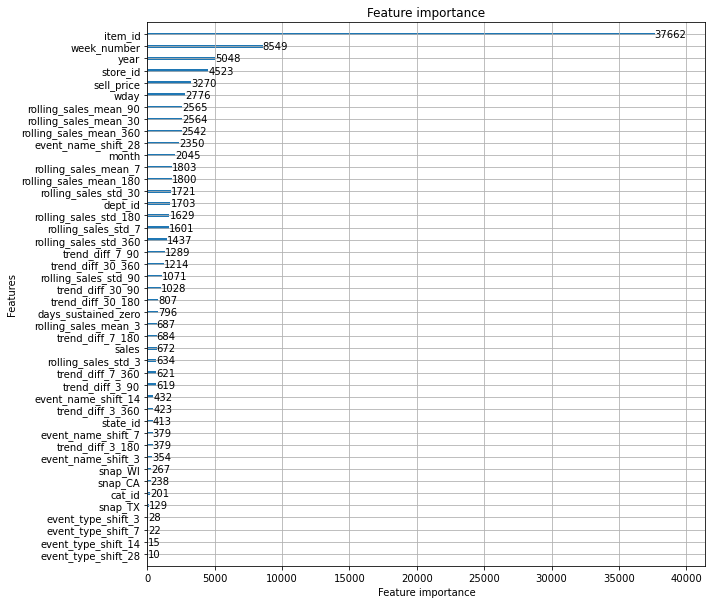

<IPython.core.display.Javascript object>

In [211]:
plot_importance(lgbm_models[-1], figsize=(10, 10))